Run in an environment with only scvelo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import anndata
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import scvelo as scv

In [2]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# Velocity

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
scv.tl.recover_dynamics(adata, n_jobs=-1)

recovering dynamics (using 16/16 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:02:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [5]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_velo_umap.png


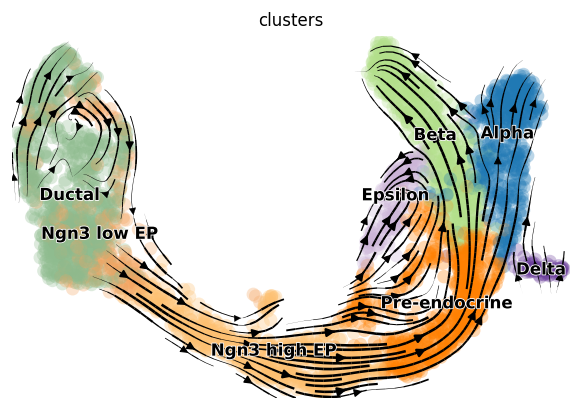

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap', dpi=120, save='velo_umap.png')
#plt.title('scvelo')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


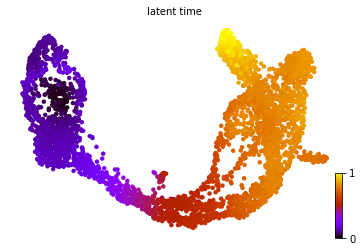

In [8]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

# GRN

In [9]:
future_df = pd.read_csv('./saved_links_loss_pancreas/prediction_present_future.csv', index_col=0)

In [10]:
no_estan = list(set(list(adata.to_df().columns)) - set(list(future_df.columns)))

In [11]:
df_no_estan = pd.DataFrame(np.zeros((future_df.shape[0], len(no_estan))))
df_no_estan.columns = no_estan

In [12]:
future_df_all =pd.concat([future_df, df_no_estan], axis=1)
future_df_all.index = adata.obs.sort_values(by='latent_time').index
future_df_all = future_df_all[list(adata.to_df().columns)]
future_df_all = future_df_all.sort_index()

In [13]:
#add layers
adata.layers['future'] = np.array(future_df_all)
adata.layers['grn'] = adata.to_df('future') - adata.to_df('Ms')

In [14]:
#compute velocity_graph
scv.tl.velocity_graph(adata, vkey='grn')

computing velocity graph
    finished (0:00:09) --> added 
    'grn_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
scv.tl.velocity_embedding(adata, vkey = 'grn')

computing velocity embedding
    finished (0:00:00) --> added
    'grn_umap', embedded velocity vectors (adata.obsm)


saving figure to file ./figures/scvelo_stream_grn.png


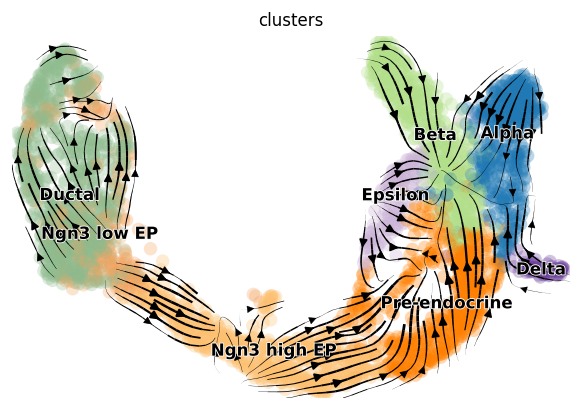

In [16]:
scv.pl.velocity_embedding_stream(adata, vkey='grn', dpi=120, save='stream_grn.png')